In [14]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree=20                               # 多项式的最大阶数
n_train,n_test=100,100                      # 训练和测试数据集大小
true_w=np.zeros(max_degree)                 # 分配大量的空间
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)     # gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)         # labels的维度:(n_train+n_test,)
labels+=np.random.normal(scale=0.1,size=labels.shape)
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]  # NumPy ndarray转换为tensor
features[:2],poly_features[:2,:],labels[:2]


(tensor([[0.1728],
         [0.7047]]),
 tensor([[1.0000e+00, 1.7277e-01, 1.4925e-02, 8.5955e-04, 3.7126e-05, 1.2829e-06,
          3.6941e-08, 9.1176e-10, 1.9691e-11, 3.7800e-13, 6.5309e-15, 1.0258e-16,
          1.4769e-18, 1.9628e-20, 2.4222e-22, 2.7900e-24, 3.0127e-26, 3.0618e-28,
          2.9389e-30, 2.6724e-32],
         [1.0000e+00, 7.0474e-01, 2.4833e-01, 5.8336e-02, 1.0278e-02, 1.4487e-03,
          1.7015e-04, 1.7131e-05, 1.5091e-06, 1.1817e-07, 8.3278e-09, 5.3354e-10,
          3.1334e-11, 1.6986e-12, 8.5508e-14, 4.0174e-15, 1.7695e-16, 7.3356e-18,
          2.8720e-19, 1.0653e-20]]),
 tensor([5.0506, 5.2309]))

In [113]:
import matplotlib.pyplot as plt

def plot(pred_w=None):
    x=np.arange(min(features),max(features),0.01).reshape(-1,1)
    true_y=5+1.2*x-3.4*x**2/2+5.6*x**3/6
    if pred_w is not None:
        pred_y=np.zeros_like(x)
        for(i,w) in enumerate(pred_w[0]):
            pred_y+=w*x**i/math.gamma(i+1)
        plt.plot(x,pred_y,c='g',label='pred')
    plt.scatter(features.reshape(-1).numpy(),labels.numpy(),marker='.')
    plt.plot(x,true_y,c='r',ls='--',label='true')
    plt.xlim(-4,4),plt.ylim(-40,40),plt.grid(),plt.legend()

In [52]:
def evaluate_loss(net,data_iter,loss):
    """评估给定数据集上模型的损失"""
    metric=d2l.Accumulator(2)   # 损失的总和,样本数量
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss=nn.MSELoss()
    input_shape=train_features.shape[-1]
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))  # 不设置偏置,因为我们已经在多项式中实现了它
    batch_size=min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())
    return net[0].weight.data.numpy()

三阶多项式函数拟合(正常)

weight: [[ 5.0073104  1.1919463 -3.4039586  5.6259475]]


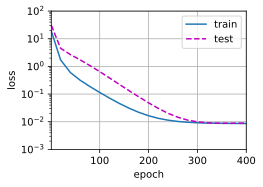

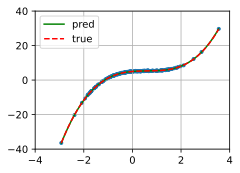

In [109]:
# 从多项式特征中选择前4个维度,即1,x,x^2/2!,x^3/3!
pred_w=train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])
plt.show(),plot(pred_w);

线性函数拟合(欠拟合)

weight: [[3.36854   3.5243995]]


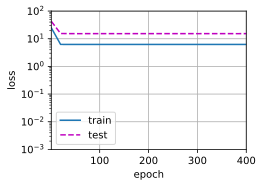

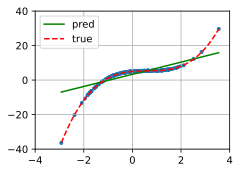

In [115]:
# 从多项式特征中选择前2个维度,即1,x
pred_w=train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])
plt.show(),plot(pred_w);

高阶多项式函数拟合(过拟合)

weight: [[ 4.9879313e+00  1.2532071e+00 -3.2907739e+00  5.2103429e+00
  -3.7929478e-01  1.4546080e+00  2.0403700e-01 -5.0302655e-03
  -1.1509256e-01  1.6109191e-01  2.4204866e-03  8.4489994e-02
   5.1850677e-02 -4.6818633e-02  1.2779410e-01  1.7572023e-01
  -1.7984627e-01  8.2705230e-02  1.3254511e-01  6.5630525e-02]]


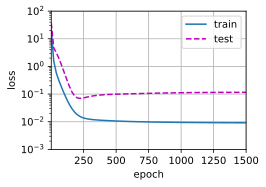

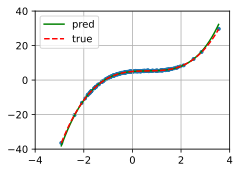

In [116]:
# 从多项式特征中选取所有维度
pred_w=train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:],num_epochs=1500)
plt.show(),plot(pred_w);

Exercises

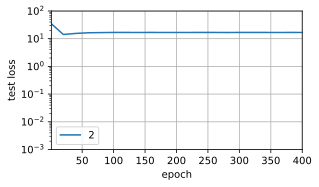

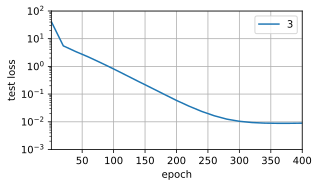

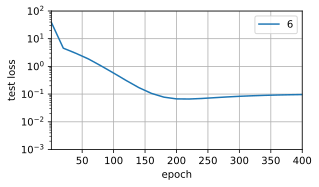

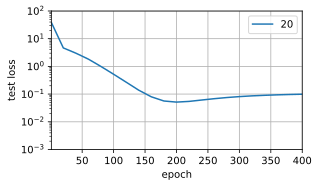

In [132]:
def train_loss(orders,num_epochs=400,mode='train'):
    loss=nn.MSELoss()
    for order in orders:
        train_features,test_features=poly_features[:n_train,:order+1],poly_features[n_train:,:order+1]
        train_labels,test_labels=labels[:n_train],labels[n_train:]
        input_shape=train_features.shape[-1]
        batch_size=min(10,train_labels.shape[0])
        train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
        test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
        net=nn.Sequential(nn.Linear(input_shape,1,bias=False))
        trainer=torch.optim.SGD(net.parameters(),lr=0.01)
        if mode=='train':
            animator=d2l.Animator(xlabel='epoch',ylabel='train loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=[str(order)],figsize=(4.5,2.5))
        else:
            animator=d2l.Animator(xlabel='epoch',ylabel='test loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=[str(order)],figsize=(4.5,2.5))
        for epoch in range(num_epochs):
            d2l.train_epoch_ch3(net,train_iter,loss,trainer)
            if epoch==0 or (epoch+1)%20==0:
                if mode=='train':
                    animator.add(epoch+1,(evaluate_loss(net,train_iter,loss)))
                else:
                    animator.add(epoch+1,(evaluate_loss(net,test_iter,loss)))

train_loss([2,3,6,20],num_epochs=400,mode='test')